In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import model_selection, linear_model, metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

In [4]:
import zipfile
import os
def fetch_data(path):
    z = zipfile.ZipFile(path, 'r')
    z.extractall(path=os.path.join(".", "dataset"))
    z.close()

In [5]:
path = 'dataset/gt.zip'
fetch_data(path)

In [6]:
raw_data = pd.read_csv('dataset/GlobalTemperatures.csv',sep=',')

In [7]:
raw_data.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
raw_data.shape

(3192, 9)

In [9]:
raw_data.isnull().values.any()

True

## Предобработка данных

### Типы признаков

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [11]:
raw_data.dt = raw_data.dt.apply(pd.to_datetime)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   dt                                         3192 non-null   datetime64[ns]
 1   LandAverageTemperature                     3180 non-null   float64       
 2   LandAverageTemperatureUncertainty          3180 non-null   float64       
 3   LandMaxTemperature                         1992 non-null   float64       
 4   LandMaxTemperatureUncertainty              1992 non-null   float64       
 5   LandMinTemperature                         1992 non-null   float64       
 6   LandMinTemperatureUncertainty              1992 non-null   float64       
 7   LandAndOceanAverageTemperature             1992 non-null   float64       
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64       
dtypes: datetime64[ns](1)

In [12]:
raw_data['month'] = raw_data.dt.apply(lambda x: x.month)
raw_data['day'] = raw_data.dt.apply(lambda x: x.day)

In [13]:
raw_data.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,month,day
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN,3,1
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN,4,1
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN,5,1


## Обучение и отложенный тест

Обучающая выборка для создания модели и обучения ее. Тестовая выборка - для проверки качества модели

In [14]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [15]:
raw_data.shape, train_data.shape, hold_out_test_data.shape

((3192, 11), (2192, 11), (1000, 11))

In [16]:
print('train period from {} to {}'.format(train_data.dt.min(), train_data.dt.max()))
print('evaluation period from {} to {}'.format(hold_out_test_data.dt.min(), hold_out_test_data.dt.max()))

train period from 1750-01-01 00:00:00 to 1932-08-01 00:00:00
evaluation period from 1932-09-01 00:00:00 to 2015-12-01 00:00:00


## Данные и целевая функция

In [17]:
## обучение
train_labels = train_data['LandAverageTemperature'].values
train_data = train_data.drop(['dt', 'LandAverageTemperature'], axis=1)
train_data.head()

,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,month,day
0,3.574,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,3.702,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2,3.076,NaN,NaN,NaN,NaN,NaN,NaN,3,1
3,2.451,NaN,NaN,NaN,NaN,NaN,NaN,4,1
4,2.072,NaN,NaN,NaN,NaN,NaN,NaN,5,1


In [18]:
## test
test_labels = hold_out_test_data['LandAverageTemperature'].values
test_data = hold_out_test_data.drop(['LandAverageTemperature', 'dt'], axis=1)
test_data.head()

,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,month,day
2192,0.268,18.216,0.213,6.340,0.226,16.263,0.133,9,1
2193,0.232,15.424,0.160,3.900,0.243,15.280,0.123,10,1
2194,0.186,11.551,0.204,0.014,0.278,14.175,0.122,11,1
2195,0.196,8.888,0.215,-2.071,0.271,13.558,0.123,12,1
2196,0.226,7.379,0.207,-3.453,0.277,13.260,0.129,1,1


## Целевая функция на обучающей выборке и на отложенном тесте

Text(0.5, 1.0, 'test data')

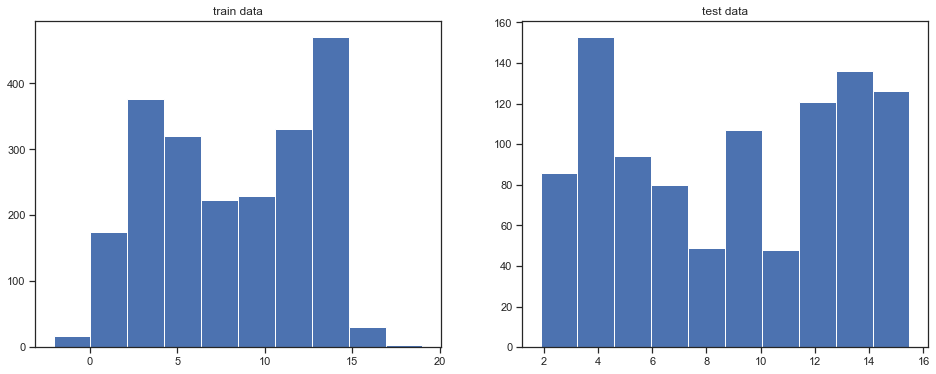

In [19]:
pylab.figure(figsize=(16,6))

pylab.subplot(1, 2, 1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1, 2, 2)
pylab.hist(test_labels)
pylab.title('test data')

## Числовые признаки

In [20]:
numeric_columns = ['LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty', 'LandAndOceanAverageTemperature', 'LandAndOceanAverageTemperatureUncertainty', 'month', 'day']

In [21]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [22]:
train_data.head()

,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,month,day
0,3.574,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,3.702,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2,3.076,NaN,NaN,NaN,NaN,NaN,NaN,3,1
3,2.451,NaN,NaN,NaN,NaN,NaN,NaN,4,1
4,2.072,NaN,NaN,NaN,NaN,NaN,NaN,5,1


In [23]:
test_data.head()

,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,month,day
2192,0.268,18.216,0.213,6.340,0.226,16.263,0.133,9,1
2193,0.232,15.424,0.160,3.900,0.243,15.280,0.123,10,1
2194,0.186,11.551,0.204,0.014,0.278,14.175,0.122,11,1
2195,0.196,8.888,0.215,-2.071,0.271,13.558,0.123,12,1
2196,0.226,7.379,0.207,-3.453,0.277,13.260,0.129,1,1


## Модель

Так как у нас регрессия, то обучим регрессор.
Моделью будет регрессор на основе стохастического градиентного спуска

In [24]:
regressor = linear_model.SGDRegressor(random_state=0)

In [25]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [41]:
test_labels[:10]

array([12.31 ,  9.682,  5.908,  3.527,  2.169,  2.657,  4.869,  8.125,
       11.047, 13.11 ])

In [42]:
regressor.predict(test_data)[:10]

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [43]:
print(list(map(lambda x: round(x, 2), regressor.coef_)))

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

Коэффициенты просто нереальны. Это происходит из-за того, что мы не отмасштабировали признаки

## Scaling

In [44]:
from sklearn.preprocessing import StandardScaler

Создаем $scaler$

Чтобы применить наше преобразование, нужно сначала его обучить(то есть высчитать параметры $\mu$ и $\sigma$)

Обучать $scaler$ можно только на обучающей выборке(потому что часто на практике нам неизвестна тестовая выборка)

In [45]:
## создаем scaler
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_trained_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Теперь можно снова обучить модель

In [46]:
regressor.fit(scaled_trained_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

**Ошибка получилось очень маленька**

Посмотрим на целефую функцию и наши прогнозы

In [47]:
test_labels[:10]

array([12.31 ,  9.682,  5.908,  3.527,  2.169,  2.657,  4.869,  8.125,
       11.047, 13.11 ])

In [48]:
regressor.predict(scaled_test_data)[:10]

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [49]:
regressor.coef_

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [50]:
print(list(map(lambda x: round(x, 2), regressor.coef_)))

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [51]:
train_data.head()

,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,month,day
0,3.574,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,3.702,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2,3.076,NaN,NaN,NaN,NaN,NaN,NaN,3,1
3,2.451,NaN,NaN,NaN,NaN,NaN,NaN,4,1
4,2.072,NaN,NaN,NaN,NaN,NaN,NaN,5,1


In [52]:
train_labels[:10]

array([ 3.034,  3.083,  5.626,  8.49 , 11.573, 12.937, 15.868, 14.75 ,
       11.413,  6.367])

In [53]:
np.all(train_data.LandMaxTemperature + train_data.registered == train_labels)

AttributeError: 'DataFrame' object has no attribute 'registered'

In [54]:
train_data.drop(['casual', 'registered'], axis=1, inplace=True)
test_data.drop(['casual', 'registered'], axis=1, inplace=True)

KeyError: "['casual' 'registered'] not found in axis"

Отмасштабируем признаки на новом наборе данных.

И обучим модель

In [55]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [56]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [57]:
print(list(map(lambda x: round(x, 2), regressor.coef_)))

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

Теперь видно, что почти все признаки вносят вклад в модель. Веса похожи на правильные

***Мы построили модель. Теперь попытаемся ее улучшить***

Для этого проведем кросс-валидацию. Но тут существует проблема: нам необходимо масштабировать данные. То есть нужно для каждого фолда провести масштабирование, а потом обучить его и проверить качество. Вся реализация будет очень громоздкой.

Благо, существует класс $Pipeline$

## Pipilene

In [ ]:
from sklearn.pipeline import Pipeline

Вместо одного преобразования, $Pipeline$ позволяет делать целую цепочку преобразований

- каждый шаг представляется $tuple$

- первый элемент: название шага, второй элемент: объект, который способен преобразовывать данные

- ***главное, чтобы у объектов были такие методы как $fit$ и $transform$***

In [ ]:
## создаем Pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps=[('scaling', scaler), ('regression', regressor)])

In [ ]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

## Подбор параметров

Параметры будем подбирать по сетке

Посмотрим сначала как правильно к ним обращаться

In [ ]:
pipeline.get_params().keys()

In [ ]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

Строим сетку

In [ ]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring='neg_mean_absolute_error', cv=4)

Обучаем сетку

In [ ]:
%%time
grid_cv.fit(train_data, train_labels)

In [ ]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

## Оценка по отложенному тесту

In [ ]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

In [ ]:
np.mean(test_labels)

In [ ]:
test_labels[:10]

In [ ]:
grid_cv.best_estimator_.predict(test_data)[:10]

Видно, что отличия довольно серьезные

Построим график наших предсказаний на целевой метке. Идеально было бы, если наши прогнозы и целевая метка совпадали и образовывали диагональ

In [ ]:
pylab.figure(figsize=(16,6))

pylab.subplot(1, 2, 1)
pylab.grid(True)
pylab.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color='blue')
pylab.title('no parameters setting')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

pylab.subplot(1, 2, 2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')
pylab.title('grid search')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

# SVM

In [ ]:
from sklearn.svm import LinearSVR, SVR, NuSVR

### Объединяем отмасштабированные тренировачную и тестовую выборку в одну, чтобы показать на графике

In [ ]:
columns = ['LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty', 'LandAndOceanAverageTemperature', 'LandAndOceanAverageTemperatureUncertainty', 'month', 'day']
df_scaled_train_data = pd.DataFrame(scaled_train_data, columns=columns)
df_scaled_train_data.shape

In [ ]:
df_scaled_test_data = pd.DataFrame(scaled_test_data, columns=columns)
df_scaled_test_data.shape

In [ ]:
df_scaled_data = pd.concat((df_scaled_train_data, df_scaled_test_data))
df_scaled_data.shape

### Объединяем метки

In [ ]:
labels = np.concatenate((train_labels,test_labels))
labels

In [ ]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=df_scaled_data.temp, y=labels)

In [ ]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(df_scaled_data, labels)
    y_pred = clf.predict(df_scaled_data)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(df_scaled_data.temp, labels, 'b.')
    ax.plot(df_scaled_data.temp, y_pred, 'ro')
    plt.show()

In [26]:
%%time
list_SVR = [LinearSVR(C=1.0, max_iter=10000), 
            LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=10000), 
            SVR(kernel='linear', C=1.0),
           SVR(kernel='rbf', gamma=0.2, C=1.0),
           SVR(kernel='rbf', gamma=0.8, C=1.0),
           NuSVR(kernel='rbf', gamma=0.8, nu=0.1, C=1.0),
           NuSVR(kernel='rbf', gamma=0.8, nu=0.9, C=1.0),
           SVR(kernel='poly', degree=2, gamma='auto', C=1.0),
           SVR(kernel='poly', degree=3, gamma=0.2, C=1.0),
           SVR(kernel='poly', degree=4, gamma=0.2, C=1.0)]
for i, svm in enumerate(list_SVR):
    pylab.figure(figsize=(4,36))
    pylab.subplot(10, 1, i + 1)
    pylab.grid(True)
    svm.fit(df_scaled_data, labels)
    y_pred = svm.predict(df_scaled_data)
    plt.plot(df_scaled_data.temp, labels, 'b.')
    plt.plot(df_scaled_data.temp, y_pred, 'ro')
    print(i+1, ":", svm)
    pylab.title(svm.__repr__)
    plt.show()
#     plot_regr(svm)

NameError: name 'LinearSVR' is not defined

In [27]:
def func():
    minimum = 100000.
    for i, svm in enumerate(list_SVR):
        svm.fit(scaled_train_data, train_labels)
        y_pred = svm.predict(scaled_test_data)
        print(str(i+1) + ") " + str(svm) + ":")
        MAE = metrics.mean_absolute_error(test_labels, y_pred)
        RMSE = np.sqrt(metrics.mean_squared_error(test_labels, y_pred))
        mean = (MAE + RMSE)/2.
        if float(mean) < float(minimum):
            minimum = mean
            best = (i+1, svm)
        print("MAE :", MAE)
        print("RMSE :", RMSE)
    print("The best is", best)

In [28]:
func()

NameError: name 'list_SVR' is not defined

# Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [58]:
regressor.fit(train_data, train_labels)
y_pred = regressor.predict(test_data)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [32]:
MAE = metrics.mean_absolute_error(test_labels, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(test_labels, y_pred))
print("MAE :", MAE)
print("RMSE :", RMSE)

NameError: name 'y_pred' is not defined

In [33]:
pd.DataFrame([(pair[0], '{:.2f}'.format(pair[1])) for pair in zip(test_labels[:10], 
                                                                  list(map(lambda x: round(x, 2), y_pred[:10])))], columns=['Labels', 'Predictions'])

NameError: name 'y_pred' is not defined

NameError: name 'grid_cv' is not defined

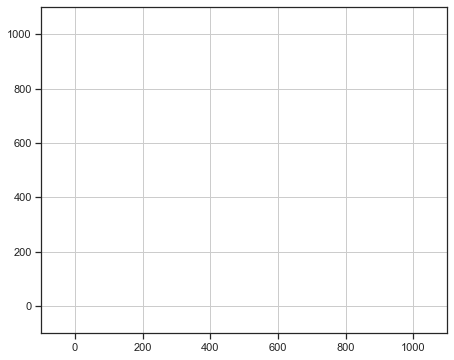

In [34]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, regressor.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, regressor.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')

In [35]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython.display import Image
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pydotplus

ModuleNotFoundError: No module named 'pydotplus'

In [36]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [37]:
# dot_data = export_graphviz(regressor)  
# graph = graphviz.Source(dot_data)  
# graph

In [38]:
decision_tree = DecisionTreeRegressor(random_state=42, max_depth=8)
decision_tree.fit(train_data, train_labels)
y_pred = decision_tree.predict(test_data)
metrics.mean_absolute_error(test_labels, y_pred)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [39]:
# Image(get_png_tree(decision_tree, train_data.columns), height="500")

In [40]:
path = os.path.join('dataset', 'GlobalTemperatures.csv')
os.remove(path)